# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import time

import numpy as np
from unityagents import UnityEnvironment

from config import Config
from maddpg import MultiAgentDDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")#, no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
state = env_info.vector_observations
state_size = state.shape[1]

print('There are {} agents. Each observes a state with length: {}'
      .format(state.shape[0], state_size))
print('The observation for the first agent looks like:\n', state[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The observation for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
## Initialize values in Config
config = Config()
config.seed = 3
config.device = 'cpu'
config.target_score = 0.5
config.target_episodes = 100

config.num_agents = num_agents
config.action_size = action_size
config.state_size = state_size

config.actor_layers = [256, 128]
config.critic_layers = [256, 128]
config.actor_lr = 1e-4
config.critic_lr = 1e-4
config.batch_normalization = True

config.buffer_size = int(1e5)
config.batch_size = 128
config.gamma = 0.99
config.tau = 5e-3
config.noise = True
config.noise_theta = 0.15
config.noise_sigma = -0.01

config.max_episodes = 300

# Instantiate a Multi Agent
maddpg = MultiAgentDDPG()

In [6]:
## Define the training function
def train(env, maddpg, max_episodes=5000):
    """Train a Multi Agent Deep Deterministic Policy Gradients (MADDPG).
    Params
    ======
        env (UnityEnvironment): environment for the agents
        maddpg (MADDPG): the Multi Agent DDPG
        n_episodes (int): maximum number of training episodes
    """
    scores = []
    agents_scores = []
    moving_avg = []

    steps = 0
    ## Perform n_episodes of training
    for i_episode in range(1, max_episodes+1):
        time_start = time.time()
        maddpg.reset_noise()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations

        scores_episode = np.zeros(config.num_agents)
        while True:
            ## Perform a step: S;A;R;S'
            actions = maddpg.act(state)
            env_info = env.step(actions)[brain_name]

            rewards = env_info.rewards
            next_state = env_info.vector_observations
            done = any(env_info.local_done)

            maddpg.store(state, actions, rewards, next_state)

            state = next_state
            scores_episode += rewards

            if done:
                break

        agents_scores.append(scores_episode)
        scores.append(scores_episode.max())
        moving_avg.append(np.mean(scores[-config.target_episodes:]))

        print('\rEpisode {:4d}   ' \
              'Last score: {:5.2f} ({:5.2f} / {:5.2f})   ' \
              'Mov. score: {:5.2f}   Mov. average: {:5.3f}'
              .format(i_episode,
                      scores[-1], scores_episode[0], scores_episode[1],
                      np.sum(scores[-config.target_episodes:]), moving_avg[-1]),
              end='')
        if i_episode % 100 == 0:
            print()

        ## Check if the environment has been solved
        if moving_avg[-1].mean() >= config.target_score \
                and i_episode >= config.target_episodes:
            print('\n\nEnvironment solved in {:d} episodes!\t' \
                  'Moving Average Score: {:.3f}'
                  .format(i_episode-config.target_episodes, moving_avg[-1]))
            break

    print('\n')
    return scores, agents_scores, moving_avg

In [7]:
## Train the agent
%time scores, agent_scores, moving_avg = train(env, maddpg, config.max_episodes)

Episode  100   Last score:  0.00 ( 0.00 / -0.01)   Mov. score:  0.87   Mov. average: 0.009
Episode  200   Last score:  0.00 (-0.01 /  0.00)   Mov. score:  1.44   Mov. average: 0.014
Episode  300   Last score:  0.00 ( 0.00 / -0.01)   Mov. score:  1.06   Mov. average: 0.011


Wall time: 8min 40s


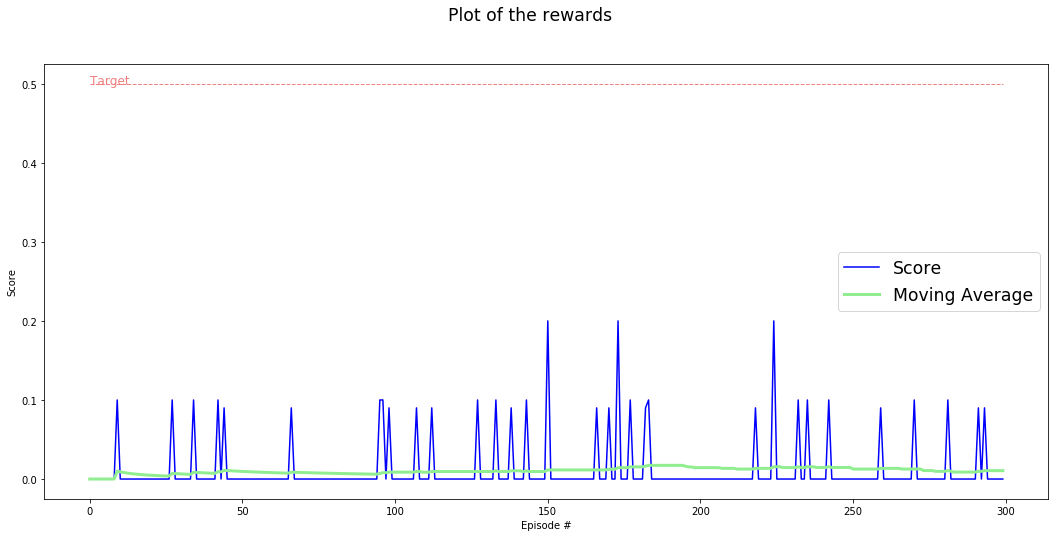

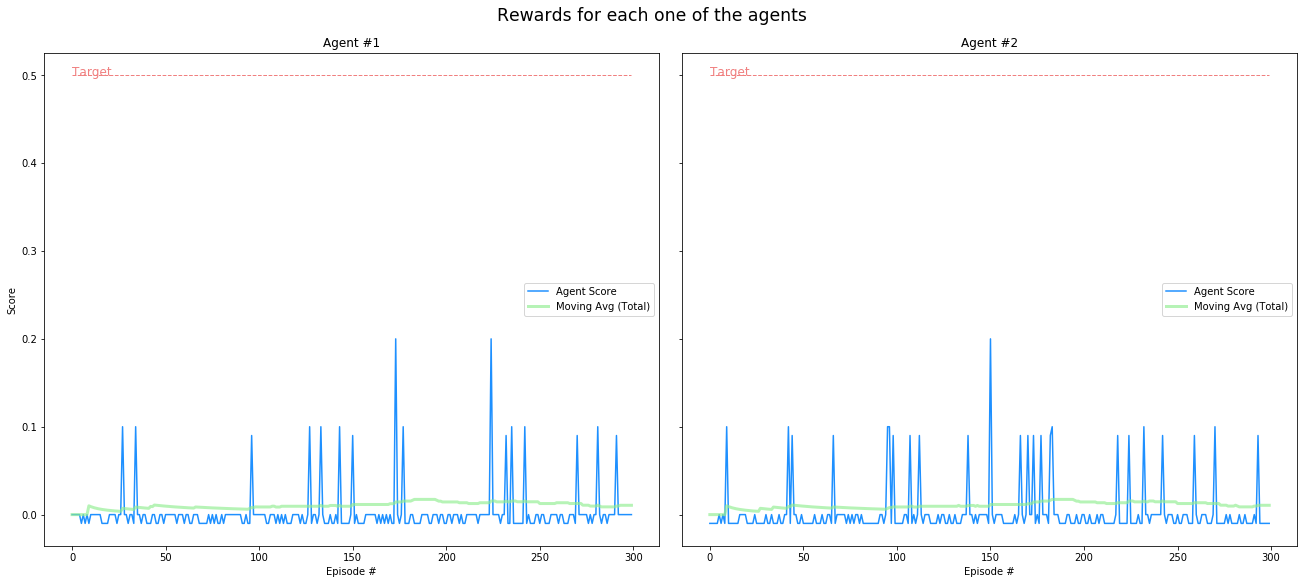

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Trace a line indicating the target value
target = [config.target_score] * len(scores)

fig = plt.figure(figsize=(18,8))
fig.suptitle('Plot of the rewards', fontsize='xx-large')
ax = fig.add_subplot(111)
ax.plot(scores, label='Score', color='Blue')
ax.plot(moving_avg, label='Moving Average',
        color='LightGreen', linewidth=3)
ax.plot(target, linestyle='--', color='LightCoral', linewidth=1 )
ax.text(0, config.target_score, 'Target', color='LightCoral', fontsize='large')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend(fontsize='xx-large')#, loc='lower right')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 8),
        constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Rewards for each one of the agents', fontsize='xx-large')

axs = axs.flatten()
for idx, (ax, s) \
        in enumerate(zip(axs, np.transpose(agent_scores))):
    ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
    ax.plot(moving_avg, label='Moving Avg (Total)',
            color='LightGreen', linewidth=3, alpha=0.655, zorder=2)
    ax.plot(target, linestyle='--', color='LightCoral', linewidth=1, zorder=0)
    ax.text(0, config.target_score, 'Target', color='LightCoral', fontsize='large')

    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('Episode #')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.show()